# The Art of Color: How Katherine Mansfield Combines Colors in Her Short Stories

## Yinuo Liu

14 August 2022

Introduction to Computational Literary Analysis

Department of Digital Humanities, University of California, Berkeley

Instructor: Jonathan Reeve

In [1]:
import requests
import nltk
import networkx
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from nltk.corpus import wordnet as wn
from nltk.sentiment import SentimentIntensityAnalyzer

## Introduction

Katherine Mansfield is a writer well known not only for her ability to create short stories, but also for her sense of the power of the visual arts to communicate through principles of color. Her use of colors was described as “resembles the Impressionist's law of subjective compensatory color” (van Gunsteren, 167). In the master thesis of Carol Barsky, color was studied as one of the three major principles of visual art along with line and composition in Mansfield's early-time short stories, which were collected in the book *The Short Stories of Katherine Mansfield*. Barsky found that Mansfield relied on black and white when she first attempted to merge the visual arts with fiction, as shown in *The Tiredness of Rosabel* (1908). But she soon began to use more colors to create vivid pictures of characters and settings, such as the three basic hues (red, yellow, and blue) and three secondary colors (orange, green, and violet, the combinations of two basic hues), as shown in her works like *How Pearl Button was Kidnapped* (1912) and *Old Underwood* (1912). I noticed that this change happened in a short period of time, less than four years. As she wrote more stories in her later years, such as *The Daughters of the Late Colonel* (1920), *Her First Ball* (1921), *The Garden Party* (1921), and so on, I wanted to explore if colors were still used and how they were used in these late works.

In this project, I used the fifteen stories in *The Garden Party and Other Stories* as my corpus, which are her late works. I explored the frequency of color words in each story and found that colors were used widely. I then built a color network to show how colors were used together as color combinations. Finally, I analyzed the sentiment of colors, compared the same color across different stories, and compared a pair of complementary colors and a pair of similar colors. Besides the computation, I also took a closer look at the text to examine the use of color. I found Mansfield's choice of color scheme to be the art of color.


In [2]:
# In the following cells of codes, I built my corpus of Mansfield's fifteen stories.

# read the text and check 
response = requests.get('https://www.gutenberg.org/cache/epub/1429/pg1429-images.html')
response.ok

True

In [3]:
# The text read is a collection of the whole book, so different stories need to be separated.

def Clean(text):
    """
    This function is to preprocess the text. It removes some website marks.
    
    Input: string
    Output: string
    
    """
    paragraph = text.split('\r\n<h3>')
    newPara = []
    for item in paragraph:
        start = item.find('<p>')
        para = item[start:]
        newPara.append(para)
    newPara = ' '.join(newPara)
    punc = ['\n','\r','</p>','<p>','<i>','</i>','</div>']
    for item in punc:
        newPara = newPara.replace(item, '')
    return newPara

# get the title of each story
myTitle = []
rawText = response.text
for chapter in range(1,16):
    if chapter < 10:
        start = rawText.find(f'href="#chap0{chapter}"')
    else:
        start = rawText.find(f'href="#chap{chapter}"')
    text = rawText[start:]
    end = text.find('</a></td>')
    title = text[len('href="#chap01" class="pginternal">'):end]
    myTitle.append(title)

# build my corpus as a dictionary: key=title of one story, value=corresponding text (string)
myCorpus = {}
rawText = response.text
rawText = rawText[rawText.find('<div class="chapter">'):]
for chapter in range(0,15):
    start = rawText.find(myTitle[chapter])
    end = rawText.find('<!--end chapter-->')
    text = rawText[start+len(myTitle[chapter])+len('</h2>\r\n'):end]
    rawText = rawText[end+len('<!--end chapter-->'):]
    myCorpus[myTitle[chapter]] = Clean(text)

# print out some texts to check my corpus
for chapter in range(0,15):
    text = myCorpus[myTitle[chapter]]
    print(f'{myTitle[chapter]}:\n{text[:100]}\n')

At the Bay:
Very early morning. The sun was not yet risen, and the whole of Crescent Bay was hidden under a whit

The Garden-Party:
And after all the weather was ideal. They could not have had a more perfect day for a garden-party i

The Daughters of the Late Colonel:
The week after was one of the busiest weeks of their lives. Even when they went to bed it was only t

Mr. and Mrs. Dove:
Of course he knew—no man better—that he hadn’t a ghost of a chance, he hadn’t an earthly. The very i

The Young Girl:
In her blue dress, with her cheeks lightly flushed, her blue, blue eyes, and her gold curls pinned u

Life of Ma Parker:
When the literary gentleman, whose flat old Ma Parker cleaned every Tuesday, opened the door to her 

Marriage à la Mode:
On his way to the station William remembered with a fresh pang of disappointment that he was taking 

The Voyage:
The Picton boat was due to leave at half-past eleven. It was a beautiful night, mild, starry, only w

Miss Brill:
Although it was so br

## Lexical Frequency Analysis

To examine Mansfield's use of color, firstly I did a basic frequency analysis of color words. Because each story has a different word count, counting frequencies is more appropriate than counting their occurrences.

In order to include all color words, I used WordNet to make the definition: the hyponyms of 'color' are all color words.

In [4]:
def getHyponym(word):
    """
    This function gets the hyponyms of the input word.
    """
    return word.hyponyms()

def getLemmas(tree):
    """
    This function gets the all lemmas of the input tree (root and leaves).
    """
    lemmas = []
    for node in tree:
        if type(node) == nltk.corpus.reader.wordnet.Synset:
            lemma = node.lemma_names()
            for lem in lemma:
                lemmas.append(lem)
        else: # is a list
            lemma = getLemmas(node)  # recursive  
            for lem in lemma:
                lemmas.append(lem)
    return lemmas

def countedColor(textString, colorString):
    """
    This function counted the color words in a text in the form of token. 
    
    Input: textString is the text to be searched, 
           colorSrting contains the color(s) you want to search and count
    Output: a Counter contains all colors and their number of occurrences
    """
    tokens = nltk.word_tokenize(textString)
    colorToken = []
    for token in tokens:
        if token in colorString:
            colorToken.append(token)
    counted = Counter(colorToken)
    return(counted)

def numWords(textString):
    """
    This function gets the number of tokens of the input text. 
    """
    tokens = nltk.word_tokenize(textString)
    return(len(tokens))

# get the color words
color = wn.synsets('color')[0]
colorTree = color.tree(rel=getHyponym)
myColor = getLemmas(colorTree)

# to tokenize the text more accurately, we need to make the text cleaner without any punctuation
myCorpusClean = {}
for title, text in myCorpus.items():
    text = text.lower()
    for punc in ['.',',','?','!','-',':','’','”','“','<','>',';','*','—']:
        text = text.replace(punc, ' ')
    myCorpusClean[title] = text

# count the color words in each story 
allCounts = {key:countedColor(text, myColor) for key, text in myCorpusClean.items()}
allDF = pd.DataFrame(allCounts).fillna(0)

In [5]:
allDF

,At the Bay,The Garden-Party,The Daughters of the Late Colonel,Mr. and Mrs. Dove,The Young Girl,Life of Ma Parker,Marriage à la Mode,The Voyage,Miss Brill,Her First Ball,The Singing Lesson,The Stranger,Bank Holiday,An Ideal Family,The Lady’s Maid
white,14.0,2.0,4.0,1.0,5.0,2.0,2.0,10.0,2.0,5.0,0.0,5.0,2.0,3.0,2.0
blue,21.0,2.0,1.0,3.0,5.0,1.0,2.0,3.0,3.0,0.0,3.0,0.0,3.0,1.0,1.0
darkness,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yellow,8.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,2.0,2.0,1.0,0.0
red,11.0,1.0,4.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,1.0,3.0
black,15.0,3.0,10.0,0.0,4.0,4.0,3.0,9.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0
brown,5.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
pink,11.0,2.0,0.0,2.0,3.0,0.0,2.0,1.0,0.0,6.0,2.0,1.0,3.0,0.0,0.0
green,4.0,5.0,1.0,5.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0
gold,7.0,2.0,2.0,2.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0


It is noticed that there are some ambiguous words. For example, 'chocolate' can be a noun, which is just chocolate, and it can also be a color word, indicating a color similar to chocolate. I looked at the text and found almost all the ambiguous words were actually nouns.

However, there are two ways of thinking about this issue. The most common idea is that since they are nouns, they do not belong to the scope of color words here, and such words should be excluded from subsequent analyses. However, we can also look at these nouns in another way. Since they also have the attribute of color, to a certain extent, we can think that these nouns imply the components of the color. Although they are nouns, they also form part of the color system of the whole story. Just like in a painting, any object has its color, and objects and their colors together constitute the picture of the painting.

It's hard to say whether Mansfield actually considered the color properties behind the nouns when writing these stories, so I examined both ideas in the following analyses. That is, I'll then have two sets of colors, one with all nouns removed and only pure color words remained. Words like 'darkness' and 'blackness' also remained because I regarded them as variants of 'black', and 'whiteness' also remained as a variant of 'white'. There remain 47 words and I'll call this set 'color words. The other group contains all the words that appeared in the texts as hyponyms of color. There are 16 words and I'll call this set 'pure colors'.


In [6]:
# define pure color words and calculate
pureColor = ['white','blue','darkness','yellow','red','black','brown','pink','green','gold','silver','grey','orange','purple','blackness','whiteness']
pureCounts = {key:countedColor(text, pureColor) for key, text in myCorpusClean.items()}
pureDF = pd.DataFrame(pureCounts).fillna(0)

# calculate the frequency of color words in each story
allNumWords = [numWords(text) for key, text in myCorpusClean.items()]
allFreqDF = allDF / allNumWords
pureFreqDF = pureDF / allNumWords

# use the average as a measurement of how commonly they were used
allFreqDF['average'] = allFreqDF.mean(axis=1) 
pureFreqDF['average'] = pureFreqDF.mean(axis=1)

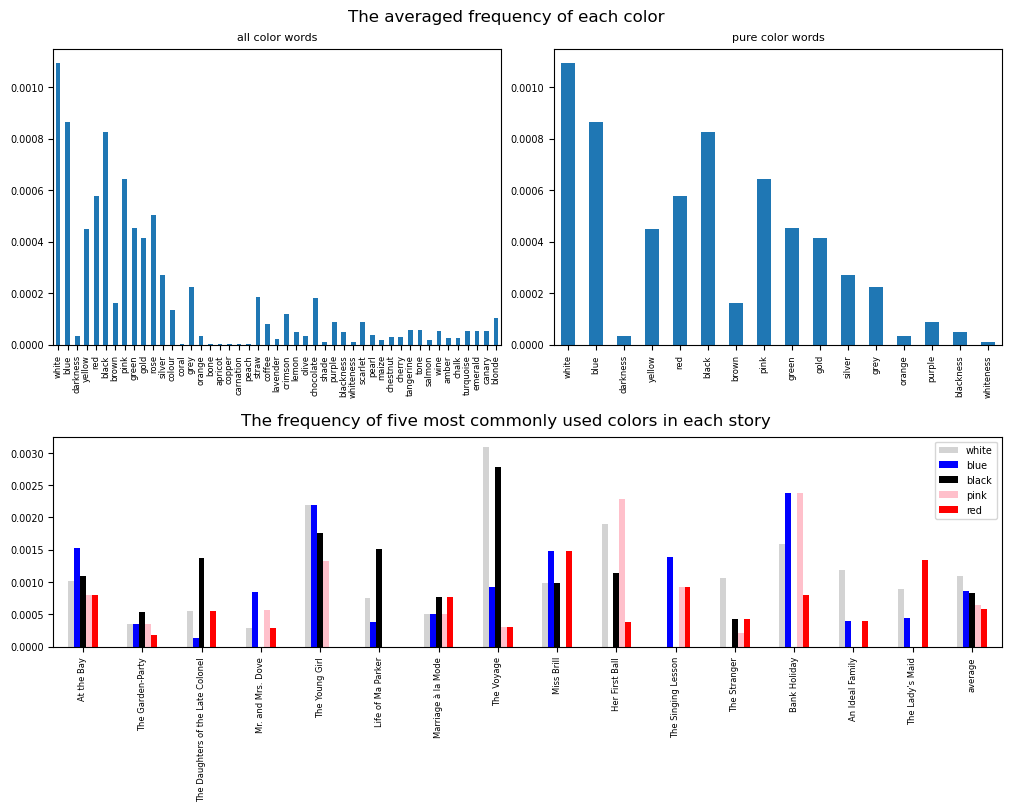

In [7]:
def figFontSize(ax):
    for size in ax.get_xticklabels():
        size.set_fontsize(6)
    for size in ax.get_yticklabels():
        size.set_fontsize(7)
    return

fig = plt.figure(figsize=(10,8), dpi=100, constrained_layout=True)
subfigs = fig.subfigures(2, 1)
for outerind, subfig in enumerate(subfigs.flat):
    if outerind == 0:
        subfig.suptitle('The averaged frequency of each color')
        axs = subfig.subplots(1, 2)
        for innerind, ax in enumerate(axs.flat):
            if innerind == 0:
                allFreqDF['average'].T.plot(kind='bar',ax=ax)
                ax.set_title('all color words',fontsize=8)
            if innerind == 1:
                pureFreqDF['average'].T.plot(kind='bar',ax=ax)
                ax.set_title('pure color words',fontsize=8)
            figFontSize(ax)
    if outerind == 1:
        subfig.suptitle('The frequency of five most commonly used colors in each story')
        axs = subfig.subplots(1, 1)
        allFreqDF.loc[list(allFreqDF['average'].sort_values(ascending=False).head(5).index)].T.plot(kind='bar',color=['lightgray','blue','black','pink','red'],ax=axs)
        figFontSize(axs)
        axs.legend(fontsize=7)

From the figure, we can see that most pure colors appeared with high frequency, such as white, blue, and black. So Mansfield still enjoyed the black-and-white scheme as she did in her earlier works. From the distribution of the five most commonly used pure colors, it can be seen that every story uses more or less of these words. This suggests that these stories use different color combinations. Color is indeed used widely in Mansfield's works.

Another interesting finding is that among the five most commonly used colors, white and black are opposites of each other, while pink and red belong to the same hue and are very harmonious. It appears that Mansfield has his own scheme for the use of color.


## Color Network

From the results above, the question "which colors were used together?" goes with the flow. To check for the color combinations, I built a color network, where each node is a color, and each edge is how many stories the pair of colors appeared together in. I again examined two sets of colors. One is all the color words including those ambiguous nouns with a color property. The other is the pure colors.

I looked at four networks. The first is the general network of all color words (including nouns). The second is the network of pure color words, as a comparison to the general network. The other two are the clusters in both two networks, with the node limit of ten colors. 

In [8]:
def makeGraph(color, corpus=myCorpusClean):
    """
    This function makes a color network. 
    
    Input: color is the colors you want to include in the network
           corpus is the content to be searched, default = my cleaned corpus
    Output: a network graph
    """
    charPairs = {pair: 0 for pair in list(combinations(color, 2))}
    for key, text in corpus.items():
        for char in charPairs:
            if char[0] in text and char[1] in text:
                charPairs[char] += 1
    graph = networkx.Graph()
    graph.add_nodes_from(color)
    for pair, weight in charPairs.items():
        if weight > 0:
            graph.add_edge(pair[0],pair[1], weight=weight)
    #networkx.draw_networkx(graph)
    pos=networkx.spring_layout(graph,iterations=len(list(combinations(color, 2))))
    edgeWidth=[]
    for (u,v,d) in graph.edges(data=True):
        tempDict = graph.get_edge_data(u,v)
        weight = tempDict['weight']/15
        edgeWidth.append(weight)
    networkx.draw_networkx_edges(graph,pos,width=edgeWidth)
    networkx.draw_networkx_nodes(graph,pos,label=color)
    networkx.draw_networkx_labels(graph,pos)
    return graph

# get some color lists
myColorUsed = list(allFreqDF['average'].sort_values(ascending=False).index)
pureColorUsed = list(pureFreqDF['average'].sort_values(ascending=False).index)

['white', 'red', 'straw']
['white', 'blue', 'black', 'red', 'green', 'yellow', 'gold', 'brown']
['white', 'blue', 'black', 'pink', 'red', 'rose', 'green', 'yellow', 'gold', 'silver']
['white', 'blue', 'black', 'pink', 'red', 'green', 'yellow', 'gold', 'silver', 'grey']


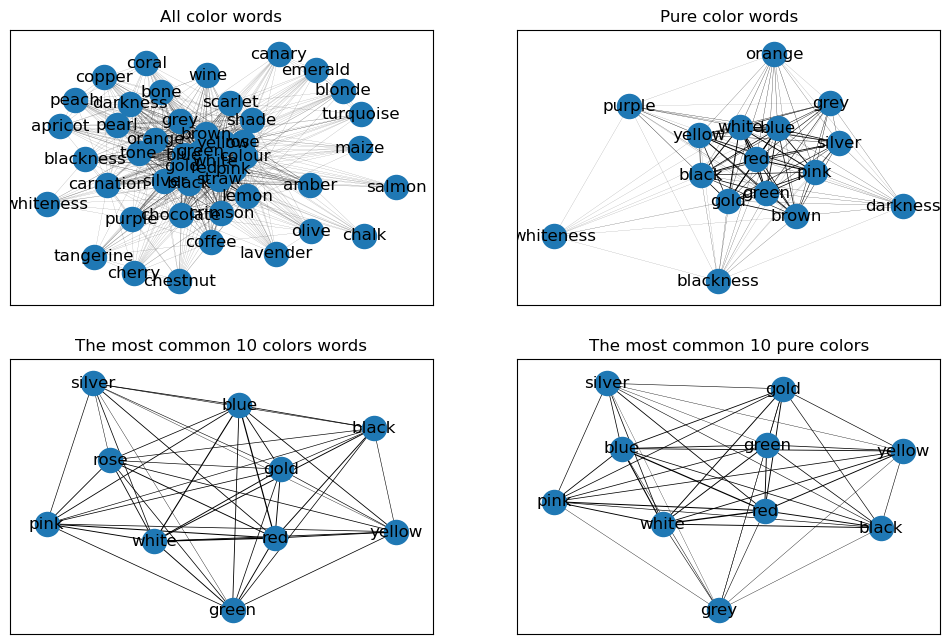

In [9]:
fig = plt.figure(figsize=(12, 8), dpi=100)
for i in range(1,5):
    ax1 = fig.add_subplot(2,2,i)
    if i == 1:
        colorGraph = makeGraph(myColorUsed)
        plt.title('All color words')
    if i == 2:
        colorGraph = makeGraph(pureColorUsed)
        plt.title('Pure color words')
    if i == 3:
        colorGraph = makeGraph(myColorUsed[:10])
        plt.title('The most common 10 colors words')
    if i == 4:
        colorGraph = makeGraph(pureColorUsed[:10])
        plt.title('The most common 10 pure colors')
    print(networkx.center(colorGraph))
    figFontSize(ax1)

From the general network of all color words, we can see a cluster of the pure colors that were used with high frequency. Nouns with the attribute of color are on the periphery. Statistical analysis showed that this network is centered on white, red, and straw. Interestingly, straw is not a word that was used a lot, but I checked and found that it did appear in most stories. As for the network of pure color, again there is a cluster. 

A closer look at the clusters of ten colors showed that both are fully connected, meaning they were used together in most cases. This result indicates that Katherine Mansfield's works are very rich in color. What is more, there are several pairs of "complementary colors" like blue and yellow (and red-green, black-white), which are opposite to each other on the color wheel. 

Complementary color schemes are appealing because "they reveal an interesting tension and provide the greatest appeal when one color is a high intensity and its complementary is subdued" (Thoma, 64). In Mansfield's color schemes, she generally indicated different intensities of colors without directly pointing the intensities out. Take *The Young Girl* for example. The description of an old woman is a typical representative.

> The ancient, withered creature, wearing a green satin dress, a black velvet cloak and a white hat with purple feathers, jerked slowly, slowly up the steps as though she were being drawn up on wires. 

To indicate different intensities of colors, she made the area of the colors different. For example, the white hat is a small part compared to the black cloak, but it forms a contrast in color. And purple is a color not commensurate with white. Although the area is smaller, it is in direct contact with white. Using these combinations, the character was shaped. What's even more amazing is that the sentence itself is not negative, but under such a color conflict, readers gain a negative impression.

A more interesting detail in this sentence is that purple and green are actually "visual complements". Dunn believes such visual complements are "true to vision" and therefore "more pleasing to viewers" than technically correct complements such as red and green. So there are actually both color contrasts and color matching. It can be said that it is like a painting.

## Sentiment Analysis

Now it's clear that there are multiple color combinations and several pairs of complementary colors in Mansfield's stories. But do complementary colors have opposite meanings? Intuitively, they should be. And this was just what Mansfield did in her early works, such as in *The Tiredness of Rosabel*, where she conventionally assigned a negative connotation to black and a positive connotation to white. But as she adopted more colors in her late works, whether or not she continued such a scheme became unknown. If Mansfield did use color as a language, each color would have a different emotional overtone and its psychological effect on readers.

Therefore, I looked at the sentiment of each pure color. The color itself is mostly neutral, so I computed the sentiment of sentences containing certain colors and used the average value as the color's sentiment.

In [10]:
def colorSen(textString, color):
    """
    This function recognizes sentences with the color.
    
    Input: textString is a text to be searched, in a string format.
           color is the color that the sentences should contain.
    Output: a list of sentences (tokenized) that contain the color
    """
    textString = textString.lower()
    sentences = nltk.sent_tokenize(textString)
    colorSen = []
    for sent in sentences:
        if color in sent:
            colorSen.append(sent)
    return colorSen

def Score(textString):
    """
    This function calculates the sentiment of the input text and outputs
    the compound score. 
    """
    sentimentAnalyzer = SentimentIntensityAnalyzer() 
    score = sentimentAnalyzer.polarity_scores(textString)['compound']
    return score

# to create a consistent text string as input
# use all the stories to get the overall sentiment
myText = []
for key, text in myCorpus.items():
    myText.append(text)
myText = ''.join(myText)

# calculate sentiment of all the color words to get a dict
# the key is a color, the value is a list of the sentiment score of each sentence
wholeColorScore = {}
for color in pureColor:
    sentences = colorSen(myText, color)
    colorScore = []
    for sent in sentences:
        score = Score(sent)
        colorScore.append(score)
    wholeColorScore[color] = colorScore
    
# get the avearaged sentiment score for each color 
wholeColorScoreMean = {}
for color, scores in wholeColorScore.items():
    score = pd.Series(scores).mean()
    wholeColorScoreMean[color] = score

For the overall sentiment, I grouped together the fifteen stories as a scope for analysis. Since the sentiment was calculated for each sentence containing color separately and then the final score was averaged among the sentences, it is actually the same as calculating the sentiment of the color in each story and then averaging the scores obtained among the stories. I would like to know what emotional component Mansfield used these colors for.

However, attention should be paid to the fact that different short stories have different themes and scene settings, and the same color may have different emotional meanings. For example, white may represent innocence, which is positive; but it may also represent paleness and despair, which is negative. Taking this into consideration, I further compared the sentiment across stories.

I picked four colors for this comparison: white, black, pink, and red. From the frequency analysis, they all belong to the five most frequently used color words. More interestingly, black and white are contrasting colors, while pink and red are matching and similar colors. So this would be a meaningful comparison between the two groups.

In [11]:
# calculate the sentiment in each story for the three most common colors
myColorScore = {}
for title in myTitle:
    distinctiveColors = ['white','black','red','pink']
    for color in distinctiveColors:
        sentences = colorSen(myCorpus[title],color)
        colorScore = []
        for sent in sentences:
            score = Score(sent)
            colorScore.append(score)
        myColorScore[f'{title} - {color}'] = colorScore

C:\Users\lyn\AppData\Local\Temp\ipykernel_19836\2098163218.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score = pd.Series(myColorScore[f'{title} - {colorList[i]}']).mean()


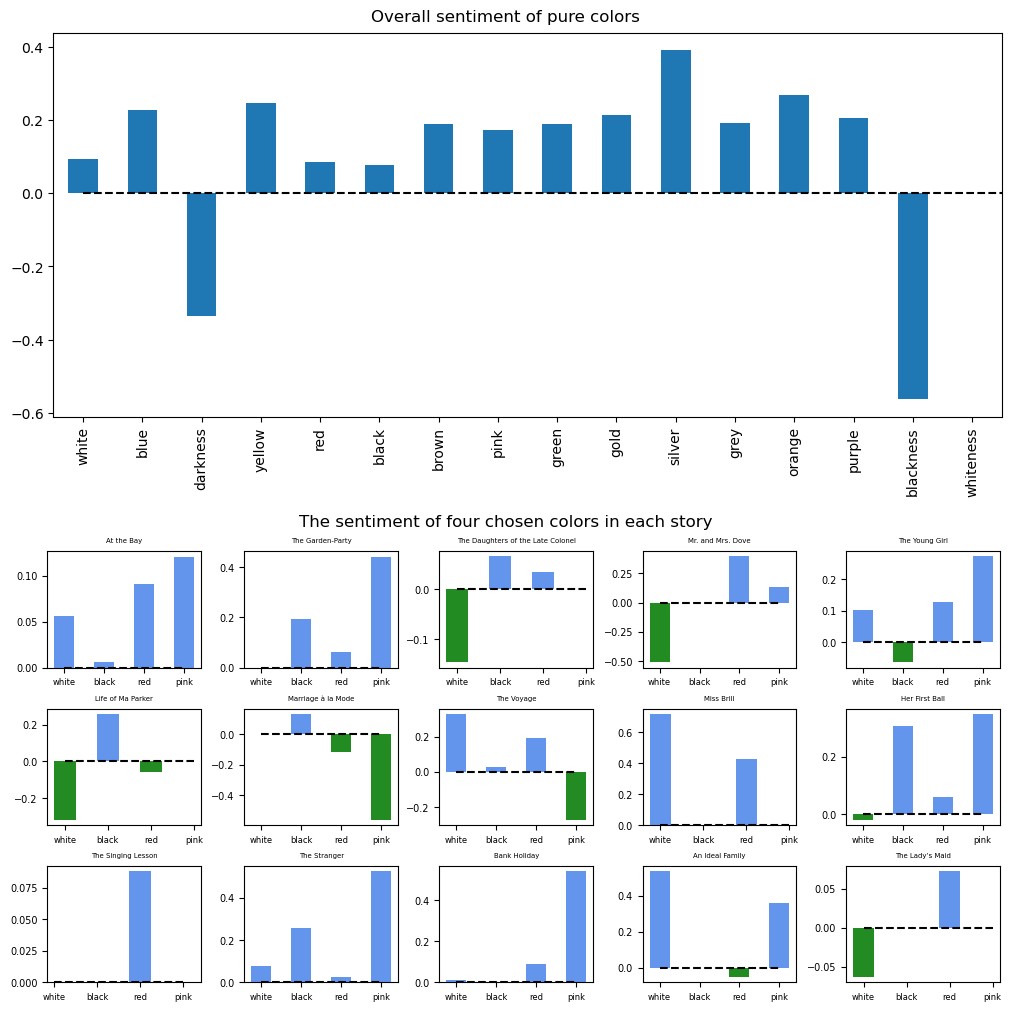

In [12]:
fig = plt.figure(figsize=(10,10), dpi=100, constrained_layout=True)
subfigs = fig.subfigures(2, 1)
for outerind, subfig in enumerate(subfigs.flat):
    if outerind == 0:
        subfig.suptitle('Overall sentiment of pure colors')
        axs = subfig.subplots(1, 1)
        pd.Series(wholeColorScoreMean).plot(kind='bar',ax=axs)
        axs.plot(range(0,len(myColorUsed)),[0]*len(myColorUsed),'k--')
    if outerind == 1:
        subfig.suptitle('The sentiment of four chosen colors in each story')
        axs = subfig.subplots(3, 5)
        colorList = ['white','black','red','pink']
        for innerind, ax in enumerate(axs.flat):
            title = myTitle[innerind]
            for i in range(0,4):
                score = pd.Series(myColorScore[f'{title} - {colorList[i]}']).mean()
                if score >= 0:
                    ax.bar(i,score,width=0.5,color='cornflowerblue')
                if score < 0:
                    ax.bar(i,score,width=0.5,color='forestgreen')
            ax.set_title(title,fontsize=5)
            ax.plot([0,1,2,3],[0,0,0,0],'k--')
            ax.set_xticks([0,1,2,3],colorList)
            figFontSize(ax)
        plt.show()

The overall sentiment of most colors is positive, while words like darkness and blackness, which have distinctly negative connotations remain negative. However, some colors have high positive values and others only have low values. A closer look at four colors across fifteen stories indicates that the same colors can have opposite emotional meanings in different stories. Therefore, a reasonable idea is that those color words with higher positive values may have consistent effects across stories, but those with lower values may play different roles depending on the theme of the text.

As for the comparison between the white-black pair and the pink-red pair, it can be easily detected that white and black, which are opposite on the color wheel, have opposite sentiments in the same story in most cases, while pink and red, which are close to each other, represent similar sentiment for almost all the time.

What is more, back to the text, similar colors like red and pink are used in similar situations. The following example is from *Her First Ball*. Not only did red and pink both capture Leila's happiness and excitement, but also they were used with a list of objects in the scene.
> She clutched her fan, and, gazing at the gleaming, golden floor, the azaleas, the lanterns, the stage at one end with its red carpet and gilt chairs and the band in a corner, she thought breathlessly, "How heavenly; how simply heavenly!"
> The lights, the azaleas, the dresses, the pink faces, the velvet chairs, all became one beautiful flying wheel. 

Conversely, opposite complementary colors like white and black were usually used in different settings. Take *The Young Girl* for example.
> We tore through the black-and-gold town like a pair of scissors tearing through brocade.
> Hennie looked rather exhausted, but she pulled on her white gloves again. 

Black appeared to be used in the description of the setting and served as the background color to make the atmosphere kind of serious, while white was related to the character. The darkness of the girl's living environment and the lack of luster in her inner life contrast sharply with the beauty of her outer appearance through black and white. 

## Limitations

There is one detail that may need further exploration. The sentiment of a sentence was analyzed from the words. Some sentences might get a positive value because the words are nice, but if we do a close reading, we can find that they are in fact shaping negative emotions. For example, in *The Young Girl*: 
> "long before that you’ll be sitting up there on the stage, looking on, in your nice black velvet. And these pretty arms will have turned into little short fat ones, and you’ll beat time with such a different kind of fan—a black bony one."

Black in the first sentence got a positive value because of words like 'nice', but it's actually expressing negative meanings. Although such sentences are not many, they still have a subtle effect on the final result, so we can think about how to take into consideration the implied meaning of the sentence when doing sentiment analysis in the future.

In addition, I'm not a native English speaker. For this project, I used past tense for the verbs related to Mansfield (e.g. color 'was' used in the stories) because I regarded the action of Mansfield took place in the past. I'm not sure if this choice of tense is correct, but I tried to make it consistent throughout the essay. In terms of writing, this essay needs to be revised and polished by native English speakers.

## Conclusion

To sum up, this project is about the art of color in Katherine Mansfield's late-time works *The Garden Party and Other Stories*. She used a lot of colors in her stories with various color schemes. Several pairs of complementary colors, which are opposite to each other, were used in these works, as well as the white-black pair, which was her first exploration of introducing colors into fiction in her early works. Further sentiment analysis suggests that the same color can have different emotional meanings in different stories. But most of the time, complementary colors had opposite sentiments and were used in different settings, while colors that are similar to each other were usually endowed with similar sentiments and used in similar ways. Mansfield revealed a great sense of the power of the visual arts to communicate through principles of color. Just as McFall claims, "there was something of the painter in Mansfield, and something about the nature of painting meaningful to her work" (McFall, 66; Barsky, 52).

## Works Cited

Barsky, Carol. "Images of Art: Katherine Mansfield's Use of Line, Color, and composition in Her Short Stories" (1996). *Masters Theses & Specialist Projects*. Paper 893. 

Dunn, Charles. *Conversations in Paint: A Notebook of Fundamentals*. New York: Workman, 1995.

McFall, Gardner. "Katherine Mansfield and the Honourable Dorothy Brett: Correspondence of Artists". Robinson 53-69.

Thoma, Marta. *Graphic Illustration: Tools and Techniques for Beginning Illustrators*. Englewood Cliffs: Prentice, 1982.

van Gunsteren, Julia. *Katherine Mansfield and Literary Impressionism*. Amsterdam: Rodopi, 1990. 
